Libraries

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import joblib
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Config

In [2]:
DATASET_PATH = r'C:\Users\aishu\Desktop\Apziva_projects\FL5MQSmgo61RrqZ5\dataset\ACME-HappinessSurvey2020.csv'

# Where to save and retrive train & test data
TRAIN_DATASET_PATH = r"C:\Users\aishu\Desktop\Apziva_projects\FL5MQSmgo61RrqZ5\dataset\train.csv"
TEST_DATASET_PATH = r"C:\Users\aishu\Desktop\Apziva_projects\FL5MQSmgo61RrqZ5\dataset\test.csv"

# input_cols =["X1", "X2", "X3", "X4", "X5", "X6"]
# target_col = "Y"

# Threshold for logistic regression
pval_threshold = 0.15
lr_coefficient_threshold = 0.4
rf_importance_threshold = 0.13
xgb_importance_threshold = 0.16
gbm_importance_threshold = 0.15
dt_importance_threshold = 0.15

# Where to save models and results
save_model_dir = r'C:\Users\aishu\Desktop\Apziva_projects\FL5MQSmgo61RrqZ5-2\models'
save_results_dir = r'C:\Users\aishu\Desktop\Apziva_projects\FL5MQSmgo61RrqZ5-2\results'

Dataset

In [3]:
dataset = pd.read_csv(DATASET_PATH)
df = dataset.copy()
df['X5*X6'] = (df['X5'] * df['X6']).astype(int)

X = df[['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X5*X6']]  
y = df['Y']

**EDA**

In [4]:
# Check for missing values
print('Null Values in dataset')
print(df.isnull().sum())
print('\n')

# Check the value ranges
print(df.describe())
print('\n')

# Check if dataset is balanced
print('Y value Count')
print(df['Y'].value_counts(normalize=True))
print('\n')

Null Values in dataset
Y        0
X1       0
X2       0
X3       0
X4       0
X5       0
X6       0
X5*X6    0
dtype: int64


                Y          X1          X2          X3          X4          X5  \
count  126.000000  126.000000  126.000000  126.000000  126.000000  126.000000   
mean     0.547619    4.333333    2.531746    3.309524    3.746032    3.650794   
std      0.499714    0.800000    1.114892    1.023440    0.875776    1.147641   
min      0.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
25%      0.000000    4.000000    2.000000    3.000000    3.000000    3.000000   
50%      1.000000    5.000000    3.000000    3.000000    4.000000    4.000000   
75%      1.000000    5.000000    3.000000    4.000000    4.000000    4.000000   
max      1.000000    5.000000    5.000000    5.000000    5.000000    5.000000   

               X6       X5*X6  
count  126.000000  126.000000  
mean     4.253968   15.825397  
std      0.809311    6.287867  
min      1.00000

Univariate Analysis

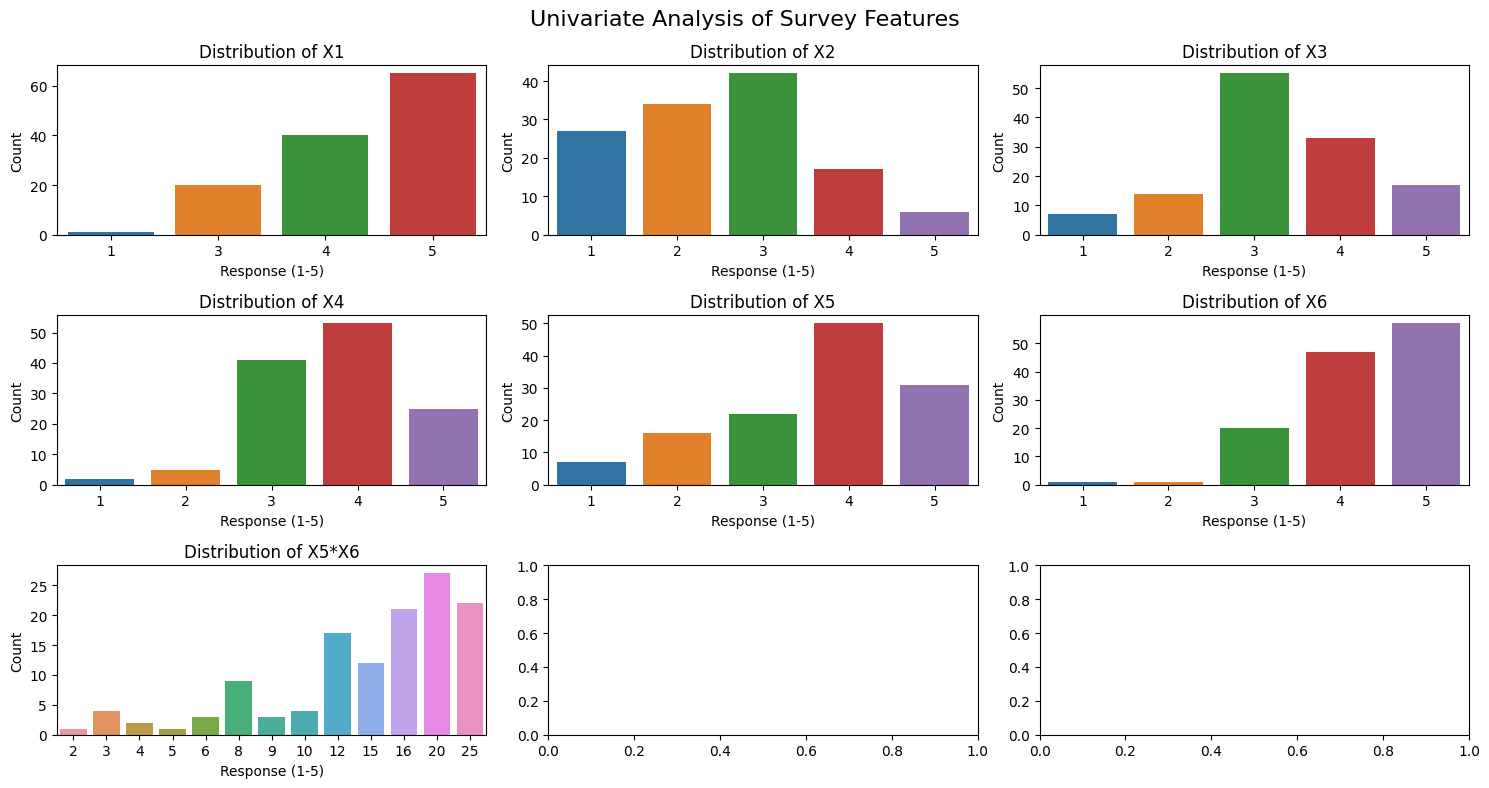

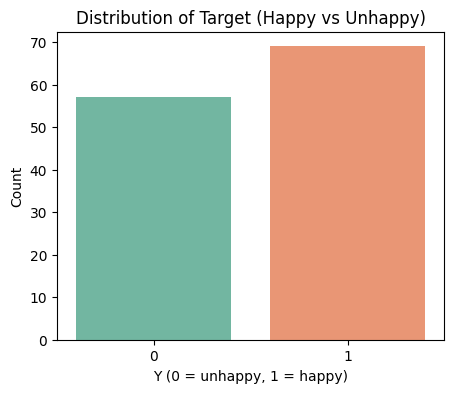

In [5]:
fig, axes = plt.subplots(3,3, figsize = (15,8))
axes = axes.flatten()

for i,col in enumerate(X.columns):
    sns.countplot(data=df, x=col, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel("Response (1-5)")
    axes[i].set_ylabel("Count")
plt.suptitle("Univariate Analysis of Survey Features", fontsize=16)
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,4))
sns.countplot(data=df, x='Y', palette="Set2")
plt.title("Distribution of Target (Happy vs Unhappy)")
plt.xlabel("Y (0 = unhappy, 1 = happy)")
plt.ylabel("Count")
plt.show()

Bivariate Analysis

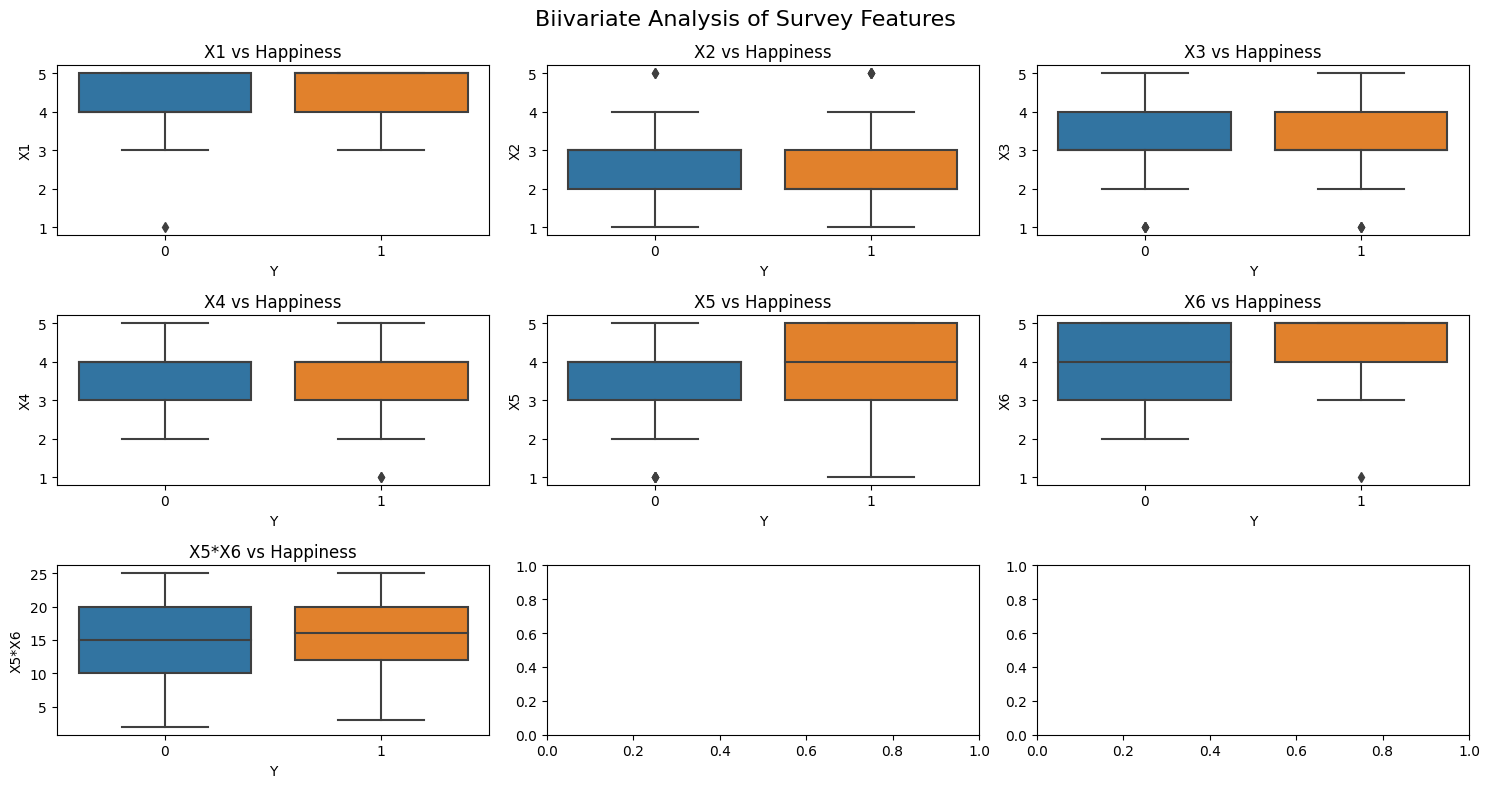

In [6]:
fig, axes = plt.subplots(3,3, figsize = (15,8))
axes = axes.flatten()

for i,col in enumerate(X.columns):
    sns.boxplot(data=df, x='Y', y=col, ax=axes[i])
    axes[i].set_title(f"{col} vs Happiness")

plt.suptitle("Biivariate Analysis of Survey Features", fontsize=16)
plt.tight_layout()
plt.show(block=False)

Mean Responses By Target

In [7]:
print('Mean Responses by Target')
print(df.groupby('Y')[['X1','X2','X3','X4','X5','X6', 'X5*X6']].mean())

Mean Responses by Target
         X1        X2        X3        X4        X5        X6      X5*X6
Y                                                                       
0  4.087719  2.561404  3.140351  3.684211  3.368421  4.105263  14.175439
1  4.536232  2.507246  3.449275  3.797101  3.884058  4.376812  17.188406


Correlation Matrix

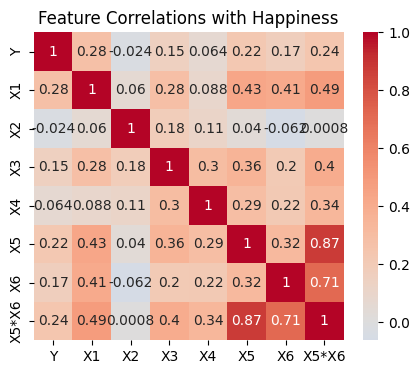

In [8]:
corr = df.corr()
plt.figure(figsize=(5,4))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title("Feature Correlations with Happiness")
plt.show()

Multivariate Analysis

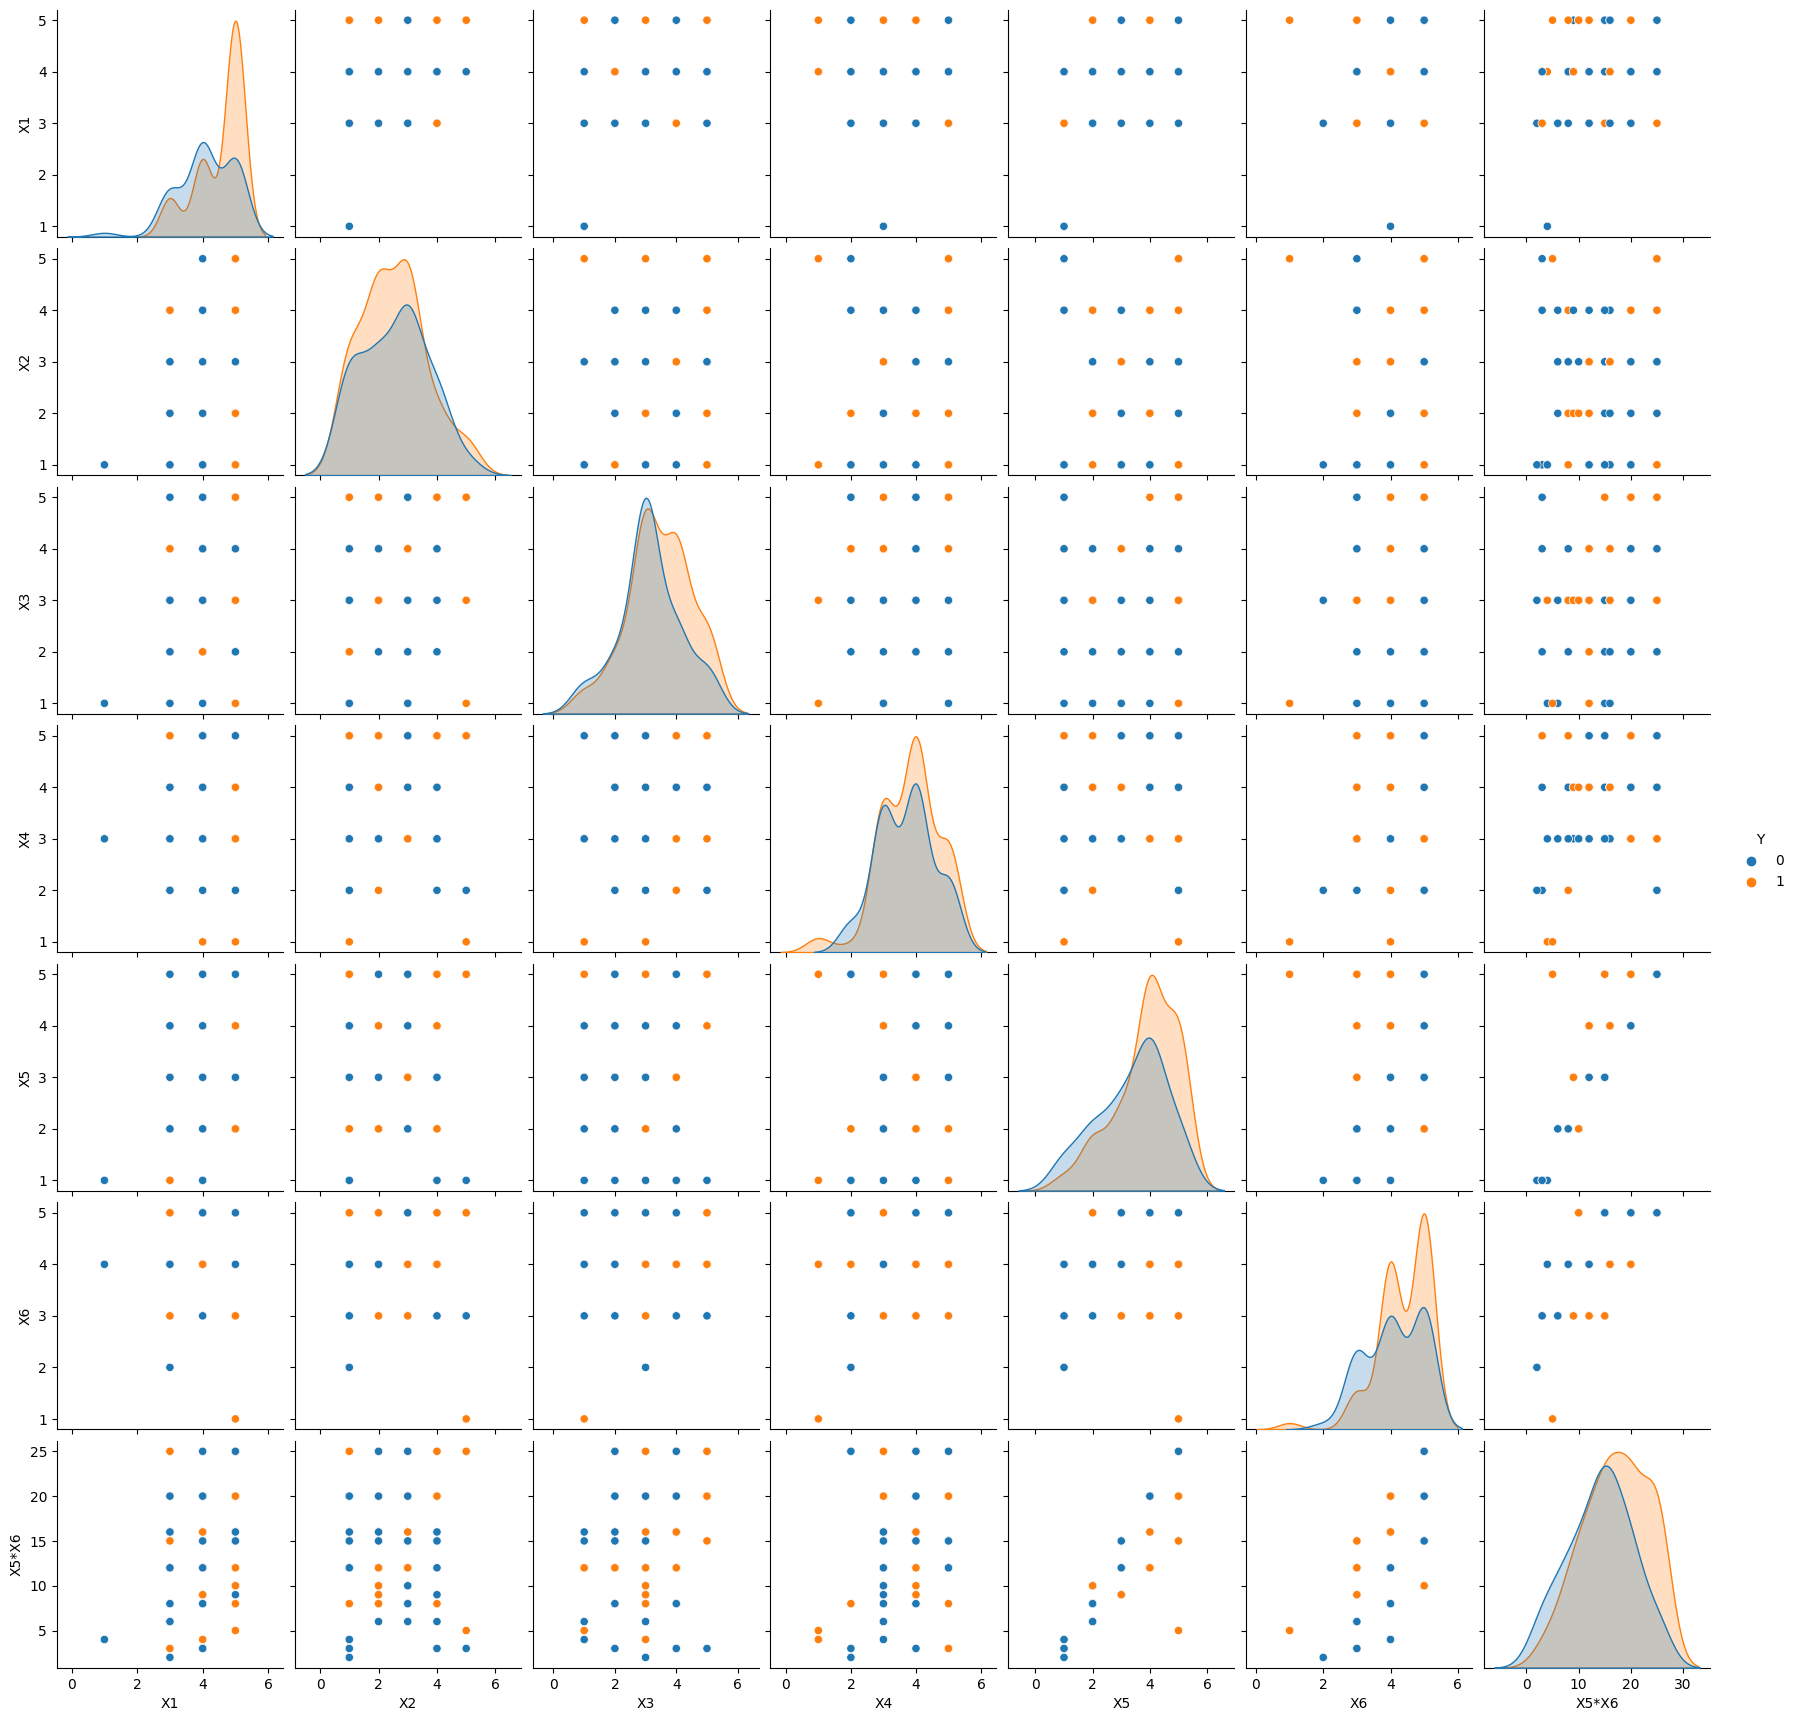

In [9]:
sns.pairplot(df, hue='Y')
plt.show()

Individual Models with no Feature Selection

In [ ]:
class IndividualModels():
    def __init__(self, *args, **kwargs):
        self.scaler = StandardScaler()
        self.lr = LogisticRegression(
            penalty='l2',
            C = 1.0,
            solver='lbfgs',
            max_iter=500,
            class_weight=None,
        )
        self.rf = RandomForestClassifier(
            n_estimators=1000,
            max_depth=None,
            min_samples_split=2,
            min_samples_leaf=1,
            max_features="sqrt", 
            bootstrap=True,         
            class_weight=None,
            random_state=42
        )
        self.xgb = XGBClassifier()
        self.gbm = GradientBoostingClassifier(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=3,
            random_state=42
        )
        self.dt = DecisionTreeClassifier(
            max_depth=None, 
            random_state=42
        )
        self.trained_models = {}
        self.is_trained = False
        self.columns = None
    
    def train(self, X_train, y_train):
        self.columns = X_train.columns.tolist()
        X_train_scaled = pd.DataFrame(self.scaler.fit_transform(X_train), columns=self.columns)
        
        print('Training LR')
        self.lr.fit(X_train_scaled, y_train)
        self.trained_models["logistic_regression"] = self.lr
        
        print('Training RF')
        self.rf.fit(X_train, y_train)
        self.trained_models["random_forest"] = self.rf

        print('Training XGB')
        self.xgb.fit(X_train, y_train)
        self.trained_models["xgboost"] = self.xgb

        print('Training GBM')
        self.gbm.fit(X_train, y_train)
        self.trained_models["gradient_boosting"] = self.gbm

        print('Training DT')
        self.dt.fit(X_train, y_train)
        self.trained_models["decision_tree"] = self.dt

        self.is_trained = True
        print('Training Complete')
    
    def save_model(self, save_model_dir=save_model_dir):
        path = os.path.join(save_model_dir, 'individual_models.pkl')
        joblib.dump({"scaler": self.scaler, "columns": self.columns, "models": self.trained_models}, path)
        print('Models Saved at: ', path)
    
    def test(self, X_test, y_test, save_results):
        if self.is_trained == False:
            raise RuntimeError("Model must be trained before testing.")
        else:
            accuracies = {}
            results_df = X_test.copy()
            results_df['y_true'] = y_test
            for model_name, model in self.trained_models.items():
                if model_name == "logistic_regression":
                    X_test_input = pd.DataFrame(
                        self.scaler.transform(X_test[self.columns]),
                        columns=self.columns
                    )
                else:
                    X_test_input = X_test[self.columns]

                acc = model.score(X_test_input, y_test)
                accuracies[model_name] = acc
                print(f"{model_name} accuracy: {acc:.4f}")
                results_df[f"y_pred_{model_name}"] = model.predict(X_test_input)
                
                if save_results == True:
                    os.makedirs(save_results_dir, exist_ok=True)
                    path = os.path.join(save_results_dir, "test_models.csv")
                    results_df.to_csv(path, index=False)
                    print(f"Combined results saved to {path}")
                # return accuracies
                
    def saved_model_test(self, X_test, y_test, model_path, save_results = True):
        saved_objects = joblib.load(model_path)
        saved_scaler = saved_objects['scaler']
        saved_columns = saved_objects["columns"]
        saved_models = saved_objects['models']

        accuracies = {}
        results_df = X_test.copy()
        results_df['y_true'] = y_test
        
        for model_name, model in saved_models.items():
            if model_name == "logistic_regression":
                X_test_input = pd.DataFrame(
                    saved_scaler.transform(X_test[saved_columns]),
                    columns=saved_columns
                )
            else:
                X_test_input = X_test[saved_columns]

            acc = model.score(X_test_input, y_test)
            accuracies[model_name] = acc
            print(f"{model_name} accuracy: {acc:.4f}")
            results_df[f"y_pred_{model_name}"] = model.predict(X_test_input)
            
            if save_results:
                os.makedirs(save_results_dir, exist_ok=True)
                path = os.path.join(save_results_dir, "test_models.csv")
                results_df.to_csv(path, index=False)
                print(f"Combined saved model results written to {path}")

Individual Models with Feature Selection 

In [11]:
class IndividualFeatureSelectedModels:
    def __init__(self):
        self.base_lr = LogisticRegression(
            penalty='l2',
            C=1.0,
            solver='lbfgs',
            max_iter=500,
            class_weight=None,
        )
        self.rf = RandomForestClassifier(
            n_estimators=1000,
            max_depth=None,
            min_samples_split=2,
            min_samples_leaf=1,
            max_features="sqrt",
            bootstrap=True,
            class_weight=None,
            random_state=42,
        )
        self.xgb = XGBClassifier()
        self.gbm = GradientBoostingClassifier(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=3,
            random_state=42,
        )
        self.dt = DecisionTreeClassifier(
            max_depth=None,
            random_state=42,
        )
        self.is_trained = False
        self.models = {}
        self.columns = None
        # feature sets
        self.lr_features = None
        self.rf_features = None
        self.xgb_features = None
        self.gbm_features = None
        self.dt_features = None

    def get_lr_coefficients_pvalues(self, X_train, y_train):
        scaler = StandardScaler()
        self.columns = X_train.columns.tolist()
        X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=self.columns)
        X_train_sm = sm.add_constant(X_train_scaled)
        logit_model = sm.Logit(y_train, X_train_sm)
        result = logit_model.fit(disp=False)  # suppress output
        pvalues = result.pvalues.drop("const")
        return result.params, pvalues

    def feature_selection(self, X_train, y_train):
        coefficients, pvalues = self.get_lr_coefficients_pvalues(X_train, y_train)
        self.lr_features = coefficients[abs(coefficients) > lr_coefficient_threshold].index.tolist()
        print("Features Selected for LR:", self.lr_features)

        self.rf.fit(X_train, y_train)
        rf_importances = pd.Series(self.rf.feature_importances_, index=X_train.columns)
        self.rf_features = rf_importances[rf_importances > rf_importance_threshold].index.tolist()
        print("Features Selected for RF:", self.rf_features)

        self.xgb.fit(X_train, y_train)
        xgb_importances = pd.Series(self.xgb.feature_importances_, index=X_train.columns)
        self.xgb_features = xgb_importances[xgb_importances > xgb_importance_threshold].index.tolist()
        print("Features Selected for XGB:", self.xgb_features)

        self.gbm.fit(X_train, y_train)
        gbm_importances = pd.Series(self.gbm.feature_importances_, index=X_train.columns)
        self.gbm_features = gbm_importances[gbm_importances > gbm_importance_threshold].index.tolist()
        print("Features Selected for GBM:", self.gbm_features)

        self.dt.fit(X_train, y_train)
        dt_importances = pd.Series(self.dt.feature_importances_, index=X_train.columns)
        self.dt_features = dt_importances[dt_importances > dt_importance_threshold].index.tolist()
        print("Features Selected for DT:", self.dt_features)

    def train(self, X_train, y_train):
        self.feature_selection(X_train, y_train)

        self.models = {
            "logistic_regression": Pipeline([
                ("select_lr_features", ColumnTransformer([("lr_features", "passthrough", self.lr_features)], remainder="drop")),
                ("scaler", StandardScaler()),
                ("lr", self.base_lr),
            ]),
            "random_forest": Pipeline([
                ("select_rf_features", ColumnTransformer([("rf_features", "passthrough", self.rf_features)], remainder="drop")),
                ("rf", self.rf),
            ]),
            "xgboost": Pipeline([
                ("select_xgb_features", ColumnTransformer([("xgb_features", "passthrough", self.xgb_features)], remainder="drop")),
                ("xgb", self.xgb),
            ]),
            "gradient_boosting": Pipeline([
                ("select_gbm_features", ColumnTransformer([("gbm_features", "passthrough", self.gbm_features)], remainder="drop")),
                ("gbm", self.gbm),
            ]),
            "decision_tree": Pipeline([
                ("select_dt_features", ColumnTransformer([("dt_features", "passthrough", self.dt_features)], remainder="drop")),
                ("dt", self.dt),
            ]),
        }

        for name, model in self.models.items():
            print(f"Training {name}...")
            model.fit(X_train, y_train)

        self.is_trained = True
        print("Training Complete")

    def save_model(self, save_model_dir=save_model_dir):
        os.makedirs(save_model_dir, exist_ok=True)
        path = os.path.join(save_model_dir, "individual_fs_models.pkl")
        joblib.dump({
            "lr_features": self.lr_features,
            "rf_features": self.rf_features,
            "xgb_features": self.xgb_features,
            "gbm_features": self.gbm_features,
            "dt_features": self.dt_features,
            "models": self.models,
        }, path)
        print("Models Saved at:", path)

    def test(self, X_test, y_test, save_results=True):
        if not self.is_trained:
            raise RuntimeError("Models must be trained before testing.")

        accuracies = {}
        results_df = X_test.copy()
        results_df["y_true"] = y_test

        for name, model in self.models.items():
            acc = model.score(X_test, y_test)
            accuracies[name] = acc
            print(f"{name} accuracy: {acc:.4f}")
            results_df[f"y_pred_{name}"] = model.predict(X_test)

        if save_results:
            os.makedirs(save_results_dir, exist_ok=True)
            path = os.path.join(save_results_dir, "test_fs_models.csv")
            results_df.to_csv(path, index=False)
            print(f"Results saved to {path}")

        # return accuracies

    def saved_model_test(self, X_test, y_test, model_path, save_results=True):
        saved_objects = joblib.load(model_path)
        saved_models = saved_objects["models"]

        accuracies = {}
        results_df = X_test.copy()
        results_df["y_true"] = y_test

        for name, model in saved_models.items():
            acc = model.score(X_test, y_test)
            accuracies[name] = acc
            print(f"{name} accuracy: {acc:.4f}")
            results_df[f"y_pred_{name}"] = model.predict(X_test)

        if save_results:
            os.makedirs(save_results_dir, exist_ok=True)
            path = os.path.join(save_results_dir, "test_saved_fs_models.csv")
            results_df.to_csv(path, index=False)
            print(f"Saved model results written to {path}")

        return accuracies


Stacked Model with GBM, XGBoost, Random Forest, Decision Tree and Logistic Regression

In [12]:
class StackedModel():
    def __init__(self):
        self.base_lr = LogisticRegression(
            penalty='l2',
            C = 1.0,
            solver='lbfgs',
            max_iter=500,
            class_weight=None,
        )
        self.rf = RandomForestClassifier(
            n_estimators=1000,
            max_depth=None,
            min_samples_split=2,
            min_samples_leaf=1,
            max_features="sqrt", 
            bootstrap=True,         
            class_weight=None,
            random_state=42
        )
        self.xgb = XGBClassifier()
        self.gbm = GradientBoostingClassifier(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=3,
            random_state=42
        )
        self.dt = DecisionTreeClassifier(
            max_depth=None, 
            random_state=42
        )
        self.is_trained = False
        self.stacked_model = None
        self.columns = None
        self.lr_features = None
        self.rf_features = None
        self.xgb_features = None
        self.gbm_features = None
        self.dt_features = None
    
    def get_lr_coefficients_pvalues(self, X_train, y_train):
        scaler = StandardScaler()
        self.columns = X_train.columns.tolist()
        X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=self.columns)
        X_train_sm = sm.add_constant(X_train_scaled)
        logit_model = sm.Logit(y_train, X_train_sm)
        result = logit_model.fit()
        # result = logit_model.fit_regularized(method='l1', alpha=0.1)
        pvalues = result.pvalues.drop('const')
        return result.params, pvalues      
        
    def feature_selection(self, X_train, y_train):
        coefficients, pvalues = self.get_lr_coefficients_pvalues(X_train, y_train)
        self.lr_features = coefficients[abs(coefficients)>lr_coefficient_threshold].index.tolist()
        # print('LR feature Coefficients:\n ', coefficients)
        print('Features Selected for LR: ', self.lr_features)
        self.rf.fit(X_train, y_train)
        rf_importances = pd.Series(self.rf.feature_importances_, index=X_train.columns)
        self.rf_features = rf_importances[rf_importances>rf_importance_threshold].index.tolist()
        # print('RF feature importances:\n ', rf_importances)
        print('Features Selected for RF: ', self.rf_features)
        self.xgb.fit(X_train, y_train)
        xgb_importances = pd.Series(self.xgb.feature_importances_, index=X_train.columns)
        self.xgb_features = xgb_importances[xgb_importances>xgb_importance_threshold].index.tolist()
        # print('XGB feature importances:\n ', xgb_importances)
        print('Features Selected for XGB: ', self.xgb_features)
        self.gbm.fit(X_train, y_train)
        gbm_importances = pd.Series(self.gbm.feature_importances_, index=X_train.columns)
        self.gbm_features = gbm_importances[gbm_importances>gbm_importance_threshold].index.tolist()
        print('Features Selected for GBM: ', self.gbm_features)
        self.dt.fit(X_train, y_train)
        dt_importances = pd.Series(self.dt.feature_importances_, index=X_train.columns)
        self.dt_features = gbm_importances[dt_importances>dt_importance_threshold].index.tolist()
        print('Features Selected for DT: ', self.dt_features)
    
    def train(self, X_train, y_train):
        self.feature_selection(X_train, y_train)
        
        lr_pipeline = Pipeline([('select_lr_features', ColumnTransformer([('lr_features', 'passthrough', self.lr_features)], remainder='drop')), 
                                ('scaler', StandardScaler()), ('lr', self.base_lr)])
        rf_pipeline = Pipeline([('select_rf_features', ColumnTransformer([('rf_features', 'passthrough', self.rf_features)], remainder='drop')), 
                                ('rf', self.rf)])
        xgb_pipeline = Pipeline([('select_xgb_features', ColumnTransformer([('xgb_features', 'passthrough', self.xgb_features)], remainder='drop')), 
                                ('xgb', self.xgb)])
        gbm_pipeline = Pipeline([('select_gbm_features', ColumnTransformer([('gbm_features', 'passthrough', self.gbm_features)], remainder='drop')), 
                                ('gbm', self.gbm)])
        dt_pipeline = Pipeline([('select_dt_features', ColumnTransformer([('dt_features', 'passthrough', self.dt_features)], remainder='drop')), 
                                ('dt', self.dt)])
        
        self.stacked_model = StackingClassifier(
            estimators=[
                ('lr', lr_pipeline),
                ('rf' ,rf_pipeline),
                ('xgb' ,xgb_pipeline),
                ('gbm' ,gbm_pipeline),
                ('dt' ,dt_pipeline)
            ],
            final_estimator=LogisticRegression(),
            cv=5,
            # stack_method='predict'
        )
        
        self.stacked_model.fit(X_train, y_train)
        self.is_trained = True
        print('Training Complete')
    
    def save_model(self, save_model_dir=save_model_dir):
        path = os.path.join(save_model_dir, 'stacked_model.pkl')
        joblib.dump({'lr_features': self.lr_features, 'rf_features': self.rf_features, 
                     'xgb_features': self.xgb_features, 'gbm_features': self.gbm_features,
                     'dt_features': self.dt_features, "model": self.stacked_model}, path)
        print('Model Saved at: ', path)
    
    def test(self, X_test, y_test, save_results = True):
        if self.is_trained == False:
            raise RuntimeError("Model must be trained before testing.")
        else:
            accuracy = self.stacked_model.score(X_test, y_test)
            print("Accuracy on Test Set with Feature Selection:", accuracy)
            
            if save_results == True:
                y_pred = self.stacked_model.predict(X_test)
                results_df = X_test.copy()
                results_df['y_true'] = y_test
                results_df['y_pred'] = y_pred
                results_df.to_csv(os.path.join(save_results_dir, 'test_with_feature_selection.csv'), index=False)
            return accuracy
    
    def saved_model_test(self, X_test, y_test, model_path, save_results = True):
        saved_objects = joblib.load(model_path)
        saved_lr_features, saved_rf_features, saved_xgb_features, saved_gbm_features, saved_dt_features = saved_objects['lr_features'], saved_objects['rf_features'], saved_objects['xgb_features'], saved_objects['gbm_features'], saved_objects['dt_features']
        saved_model = saved_objects['model']
        accuracy = saved_model.score(X_test, y_test)
        
        print('Features selected for LR are: ', saved_lr_features)
        print('Features selected for RF are: ', saved_rf_features)
        print('Features selected for XGB are: ', saved_xgb_features)
        print('Features selected for GBM are: ', saved_gbm_features)
        print('Features selected for DT are: ', saved_dt_features)
        print("Accuracy on Test Set with Stacked Mode;:", accuracy)
        
        lr_pred = saved_model.named_estimators_['lr'].predict(X_test)
        rf_pred = saved_model.named_estimators_['rf'].predict(X_test)
        xgb_pred = saved_model.named_estimators_['xgb'].predict(X_test)
        # print("LR vs RF predictions correlation:", np.corrcoef(lr_pred, rf_pred)[0,1])
        # print("RF vs XGB predictions correlation:", np.corrcoef(rf_pred, xgb_pred)[0,1])
        # print("LR vs XGB predictions correlation:", np.corrcoef(lr_pred, xgb_pred)[0,1])
        print('Model Output Coefficients [LR, RF, XGB, GBM, DT]: ', saved_model.final_estimator_.coef_)
        
        # Save predictions
        if save_results == True:
            y_pred = saved_model.predict(X_test)
            results_df = X_test.copy()
            results_df['y_true'] = y_test
            results_df['y_pred'] = y_pred
            results_df.to_csv(os.path.join(save_results_dir, 'test_with_stacked_model.csv'), index=False)
        return accuracy

Train Test Split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.15,
    random_state=42,
    stratify=y
)

# Reset Indices
X_train, X_test = X_train.reset_index(drop = True), X_test.reset_index(drop = True)
y_train, y_test = y_train.reset_index(drop = True), y_test.reset_index(drop = True)

# Combine X and y for train and test sets
train_df = pd.concat([X_train, y_train.reset_index(drop=True)], axis=1)
test_df = pd.concat([X_test, y_test.reset_index(drop=True)], axis=1)

# Save to CSV
train_df.to_csv(TRAIN_DATASET_PATH, index=False)
test_df.to_csv(TEST_DATASET_PATH, index=False)

Training the models

In [14]:
# Train Models without feature selection
print('-----------Individual Models------------------')
model_without_fs = IndividualModels()
model_without_fs.train(X_train, y_train)
# Save model
model_without_fs.save_model()

# Train Models with feature selection
print('-----------Individual Models with Feature Selection------------------')
model_fs = IndividualFeatureSelectedModels()
model_fs.train(X_train, y_train)
model_fs.save_model()

# Train Stacked Model
print('-----------Stacked Model with feature selection------------------')
model_stacked = StackedModel()
model_stacked.train(X_train, y_train)
model_stacked.save_model()

-----------Individual Models------------------
Training LR
Training RF
Training XGB
Training GBM
Training DT
Training Complete
Models Saved at:  C:\Users\aishu\Desktop\Apziva_projects\FL5MQSmgo61RrqZ5-2\models\individual_models.pkl
-----------Individual Models with Feature Selection------------------
Features Selected for LR: ['X1', 'X5']
Features Selected for RF: ['X1', 'X2', 'X3', 'X4', 'X5*X6']
Features Selected for XGB: ['X1', 'X3', 'X6']
Features Selected for GBM: ['X1', 'X3', 'X5*X6']
Features Selected for DT: ['X1', 'X2', 'X3']
Training logistic_regression...
Training random_forest...
Training xgboost...
Training gradient_boosting...
Training decision_tree...
Training Complete
Models Saved at: C:\Users\aishu\Desktop\Apziva_projects\FL5MQSmgo61RrqZ5-2\models\individual_fs_models.pkl
-----------Stacked Model with feature selection------------------
Optimization terminated successfully.
         Current function value: 0.647131
         Iterations 5
Features Selected for LR:  ['X1'

Test Models

In [15]:
# Test Models without feature selection
print('-----------Individual Models------------------')
model_without_fs = IndividualModels()
# model_without_fs.test(X_test, y_test, False)
model_path = os.path.join(save_model_dir, 'individual_models.pkl')
model_without_fs.saved_model_test(X_test, y_test, model_path)

# Test Individual Model with feature selection
print('-----------Individual Models with Feature Selection------------------')
model_with_fs = IndividualFeatureSelectedModels()
model_path = os.path.join(save_model_dir, 'individual_fs_models.pkl')
model_with_fs.saved_model_test(X_test, y_test, model_path)

# Test Stacked Model
print('-----------Stacked Model------------------')
model_stacked = StackedModel()
model_path = os.path.join(save_model_dir, 'stacked_model.pkl')
model_stacked.saved_model_test(X_test, y_test, model_path)

-----------Individual Models------------------
logistic_regression accuracy: 0.6842
Combined saved model results written to C:\Users\aishu\Desktop\Apziva_projects\FL5MQSmgo61RrqZ5-2\results\test_models.csv
random_forest accuracy: 0.5789
Combined saved model results written to C:\Users\aishu\Desktop\Apziva_projects\FL5MQSmgo61RrqZ5-2\results\test_models.csv
xgboost accuracy: 0.4737
Combined saved model results written to C:\Users\aishu\Desktop\Apziva_projects\FL5MQSmgo61RrqZ5-2\results\test_models.csv
gradient_boosting accuracy: 0.5263
Combined saved model results written to C:\Users\aishu\Desktop\Apziva_projects\FL5MQSmgo61RrqZ5-2\results\test_models.csv
decision_tree accuracy: 0.6316
Combined saved model results written to C:\Users\aishu\Desktop\Apziva_projects\FL5MQSmgo61RrqZ5-2\results\test_models.csv
-----------Individual Models with Feature Selection------------------
logistic_regression accuracy: 0.6842
random_forest accuracy: 0.4737
xgboost accuracy: 0.6842
gradient_boosting acc

0.7894736842105263